# Projet numérique de Science des Données 2025

__Binôme numéro 12 -- BAILLY Maxime et VENDEUVRE Aude__

## Introduction

Dans ce projet, il s'agira d'étudier un jeu de données concernant des femmes diabétiques enceintes. Le diabète constitue un facteur de risque pour le bon déroulé de la grossesse. Pour chacune de ces femmes, nous disposons de 7 variables :
* `Age` : l'âge en années
* `Tension systolique` : la tension systolique en mmHg
* `Tension diastolique` : la tension diastolique en mmHg
* `Glycémie` : glycémie post-prandiale en mmol/L
* `Température` : température en °C
* `FC au repos` : fréquence cardiaque au repos
* `Risque` : degré de risque obstétrique (0 : faible, 1 : moyen, 2 : élevé)


Ce projet comporte trois parties :
1. Une analyse exploratoire des données
2. La construction d'un classifieur binaire permettant de séparer les femmes dont la grossesse est à risque de celles dont elle ne l'est pas
3. La construction d'un classifieur multi-classe permettant de séparer les grossesses en trois classes : hautement à risque, moyennement à risque, faiblement à risque.

## Instructions 
* Former un binôme et l'inscrire dans Moodle.
* Renseigner le numéro de binôme et vos noms tout en haut de ce notebook à l'emplacement indiqué.
* Déposer ce notebook complété **au plus tard le 10 juillet 2025, 23h59** sur Moodle.

La présence aux séances dédiés au mini-projet (20/06 et 7/07) est **notée**. 

Les questions **1 à 14** peuvent être traitées dès la première séance. 
La question **15** peut être traitée après la PC4.
Les questions **16 à 30** peuvent être traitées à partir de la PC5.

Pour des raisons pédagogiques (voir la note à ce sujet), **l'usage d'assistants de code ou d'agents conversationnels tels que ChatGPT, Copilot, Claude, LeChat est prohibé. Leur utilisation sera sanctionnée.**

### Question 1 (1pt)

Les données ont été récoltées dans une région défavorisée du monde, où les populations sont très pauvres et peuvent difficilement consulter. Quel peut être l'intérêt de déléguer à un algorithme la prédiction du risque obstétrique ? Quelles peuvent être les dérives (sociales, éthiques, économiques, psychologiques) d'une telle pratique ?

__Réponse :__

Déléguer cette étude à un algorithme peut permettre de pallier le manque de personnel médical sur place. Cela permet aussi de gagner en efficacité en effectuant des diagnostics simultanés, de même qu'en argent. De façon plus globale, cela permet d'offrir un diagnostic à des populations n'ayant d'ordinaire pas les moyens d'accéder à ces services coûteux.

Ces bénéfices ne vont pas sans quelques inconvénients : nous pouvons imaginer qu'un tel dispositif pourrait à terme mener à une raréfaction des médecins dans des zones où l'accès à la santé est déjà précaire. Par ailleurs, le contact humain pourtant essentiel en médecine s'en voit réduit, ce qui ne va pas sans conséquences psychologiques. De plus, les compétences de l'algorithme sont certainement plus restreintes que celles d'un médecin, qui pourra éventuellement diagnostiquer un tout autre dysfonctionnement. D'un point de vue économique cette fois, il pourrait être tentant de rendre payant ce diagnostic, auprès des personnes qui le nécessitent vraiment, alors que le coût opératoire de l'algorithme est probablement faible.

## Librairies usuelles

In [ ]:
import pandas as pd

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

plt.rc('font', **{'size': 12}) # règle la taille de police globalement pour les plots (en pt)

np.random.seed(19) 

## Chargement des données

Nous allons pour l'instant travailler avec le jeu de données d'entraînement `data/donnees_entrainement.csv` :

In [5]:
df_train = pd.read_csv('data/donnees_entrainement.csv')

Commençons par en extraire deux arrays, `X_train` et `y_train`, contenant d'une part les variables décrivant les observations et d'autre part leurs étiquettes :

In [6]:
X_train = np.array(df_train.drop('Risque', axis=1)) #contient les valeurs des 6 variables
y_train = np.array(df_train['Risque'], dtype='int') #contient le risque = l'étiquette
print(X_train)

[[ 21.   85.   55.    7.   36.2  84. ]
 [ 36.  145.  100.    6.9  39.5  73. ]
 [ 15.5 120.   75.    7.4  39.   74. ]
 ...
 [ 53.5 100.   70.    7.7  36.2  68. ]
 [ 18.5 120.   70.    7.5  37.1  69. ]
 [ 21.5 100.   90.    6.8  37.3  66. ]]


# 1. Exploration de données

## Distributions des variables

### Question 2 (1 pt)
Pour chaque variable, affichez un histogramme de sa distribution dans chacune des trois classes.

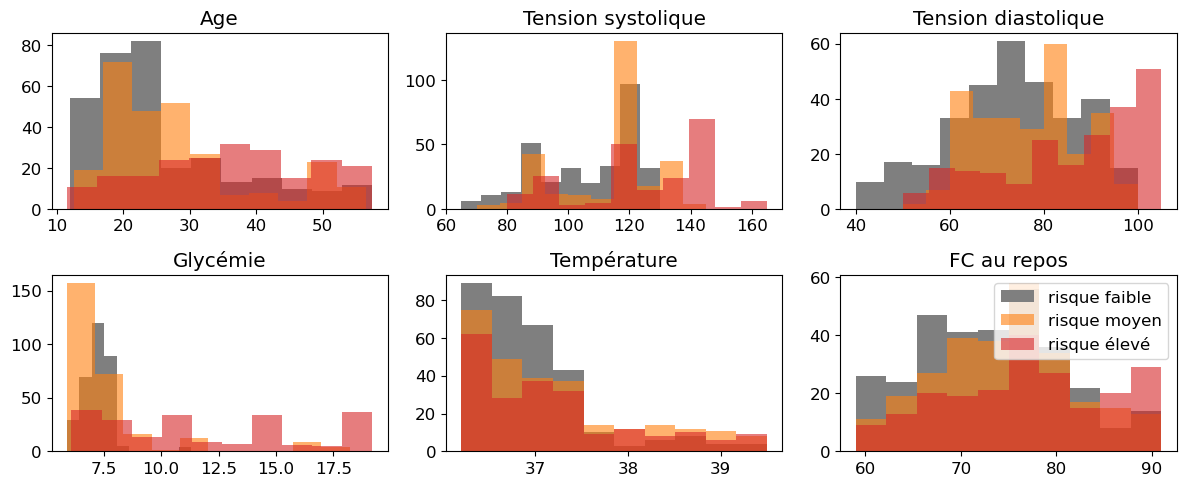

In [24]:
fig = plt.figure(figsize=(12, 5))

# Histogrammes pour les variables continues
for i, variable in enumerate(df_train.columns[:6]):
    # créer une sous-figure (subplot) à la position (i+1) d'une grille 3x6
    ax = fig.add_subplot(2, 3, (i+1))

    # afficher l'histogramme de variable pour Risque=0
    h = ax.hist(df_train[df_train['Risque']==0][variable], bins=10,  
                color='tab:grey', edgecolor='none', alpha=1, label='risque faible')
    
    # afficher l'histogramme de variable pour Risque=1
    h = ax.hist(df_train[df_train['Risque']==1][variable], bins=10,  
                color='tab:orange', edgecolor='none', alpha=0.6, label='risque moyen')

    # afficher l'histogramme de variable pour Risque=2
    h = ax.hist(df_train[df_train['Risque']==2][variable], bins=10,  
                color='tab:red', edgecolor='none', alpha=0.6, label='risque élevé')
    
    # utiliser le nom de la variable comme titre pour chaque histogramme
    ax.set_title(variable)

# Légende
plt.legend()

# espacement entre les subplots
fig.tight_layout(pad=1.0)

### Question 3 (1 pt)
Les valeurs prises par ces variables sont-elles surprenantes ? Cohérentes avec le degré de risque ?

__Réponse :__

On s'attend à ce que les valeurs prises par les variables soient d'autant plus dégradées (température haute, fréquence cardiaque haute, ...) que le risque est élevée.

Sur cet échantillon, on constate de façon assez intuitive que l'âge semble être corrélé positivement avec le niveau de risque. Il en va de même pour le taux de glycémie et les valeurs de tension, par exemple. Les valeurs semblent globalement cohérentes avec le niveau de risque. L'effet de la température est moins évident. La fréquence cardiaque au repos est assez largement étalée indépendamment du risque, mais on constate toutefois une recrudescence de FC élevées chez les personnes les plus à risque.

Les valeurs prises par les variables semblent cohérentes avec des valeurs classiques. 

### Question 4 (1 pt)
Pensez-vous qu'il va être facile/difficile de prédire le risque de grossesse à risque en utilisant ces 6 variables ?

__Réponse :__

On constate que les personnes qui voient leur grossesse classée dans les risques élevés ont globalement des variables qui prennent des valeurs plus extrêmes. Les histogrammes ne nous informent que sur ce qui se passe pour la masse, et non au niveau individuel. De plus, les histogrammes pour chaque niveau de risque sont au moins en partie superposés. On pourrait dès lors rencontrer des cas qui développent une grossesse à risque, alors que toutes leurs variables pourraient être trouvées dans les distributions "risque faible".

Il ne serait donc pas si facile de prédire le risque de grossesse à risque en utilisant ces 6 variables, et l'on pourrait chercher à rendre plus lisible l'importance de chaque variable vis-à-vis du risque réel. 

## Réduction de dimension

Indépendamment de votre réponse à la question précédente, nous allons procéder à deux tentatives de réduction de dimension.

### Question 5 (1 pt)
Utilisez la décomposition en composantes principales de `X_train` pour visualiser les données en deux dimensions.

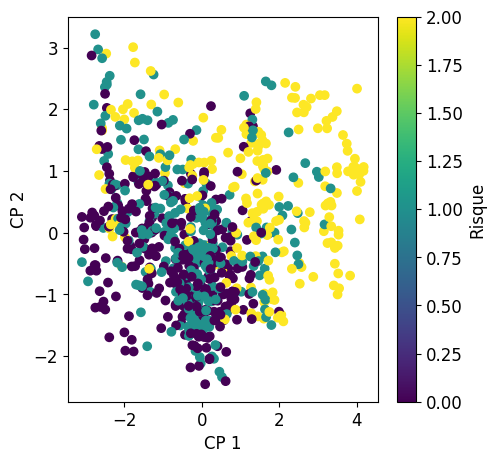

In [9]:
# On normalise les données
from sklearn import preprocessing

std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_sc = std_scale.transform(X_train)

### On décompose en composantes principales
from sklearn import decomposition

# Instanciation d'un objet PCA pour 2 composantes principales
pca = decomposition.PCA(n_components=2)
# Calcul des composantes
pca.fit(X_train_sc)

X_projected = pca.transform(X_train_sc)

fig = plt.figure(figsize=(5, 5))

plt.scatter(X_projected[:, 0], X_projected[:, 1], c=df_train['Risque'])

plt.xlabel("CP 1")
plt.ylabel("CP 2")
plt.colorbar(label='Risque')

### Question 6 (1 pt) 
Pensez-vous utile d'utiliser cette ACP pour réduire la dimension des données pour construire un prédicteur de risque de grossesse difficile ?

__Réponse :__

En colorant les points selon le risque qui leur est associé, on constate que la 1ère composante principale traduit en partie le risque. Celle-ci semble d'autant plus grande que le risque est élevé. Dans cette optique, l'ACP pourrait être intéressante. Cependant, elle permet difficilement de séparer les risques faible et moyen, ce qui la rend peu attractive. 

### Question 7 (0,5 pt)
Affichez la matrice de corrélation entre les variables (étiquette exclue)

Text(0.5, 1.0, 'Corrélation entre les différentes variables médicales')

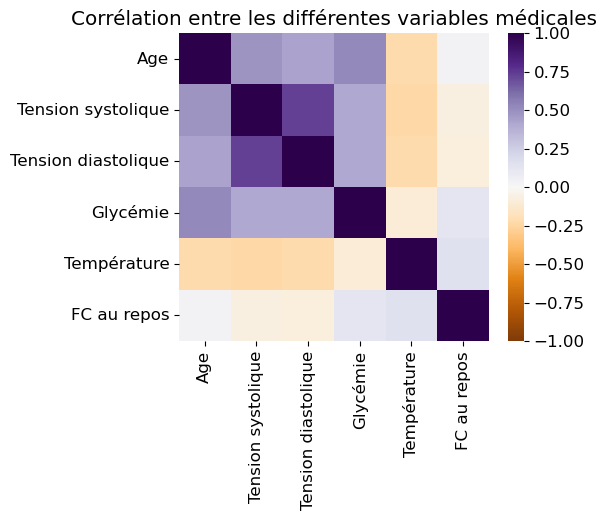

In [26]:
import seaborn as sns


# Calcul de la matrice de corrélation deux à deux
corr_matrix = df_train.drop(columns='Risque').corr()

# Initialisation figure
plt.figure(figsize=(5, 4))

# Affichage heatmap
sns.heatmap(corr_matrix, 
            vmin=-1, # borne inf des valeurs à afficher
            vmax=1, # borne sup des valeurs à afficher
            center= 0, # valeur médiane des valeurs à afficher,
            cmap='PuOr', # colormap divergente de violet (PUrple) vers orange (ORange)
           )
# Titre
plt.title("Corrélation entre les différentes variables médicales")

### Question 8 (0,5 pt)

Comment utiliser cette matrice de corrélation pour réduire la dimension des données ?

__Réponse :__

On peut estimer que si deux variables sont fortement corrélés, elles expriment la même information et sont donc redondantes. Dans notre cas, on constate que les deux tensions mesurées sont assez fortement corrélées, et éliminer l'une des deux permettrait de diminuer la dimension (de 1 seulement) sans trop perdre en informations. Les autres variables ne nous semblent pas assez corrélées pour effectuer la même opération.

# 2. Classification «à risque» vs «sans risque»

Nous allons maintenant transformer les étiquettes en étiquettes binaire, en regroupant les risques obstétriques moyens et élevés. Les étiquettes `1` et `2` seront regroupées en une seule étiquette `1`.

In [22]:
# Copier le dataframe initial dans un nouveau dataframe 
df_train_risk_vs_norisk = df_train.copy()

# Regrouper les étiquettes 1 et 2
df_train_risk_vs_norisk['Risque'] = np.where(df_train['Risque']==2, 1, df_train['Risque'])

# Extraction de l'array d'étiquettes
y_train_risk_vs_norisk = np.array(df_train_risk_vs_norisk['Risque'], dtype='int')

## Choix du critère d'évaluation
Pour cette section, on pourra se référer à la section 8.7.1 du poly.

### Question 9 (0,25 pt)
Quelle serait l'_accuracy_ (proportion d'observations correctement étiquetées) d'un modèle qui prédit que toutes les observations appartiennent à la classe majoritaire (c'est-à-dire la classe ayant le plus grand nombre d'observations dans les données) ? 

In [21]:
r = np.sum(y_train_risk_vs_norisk!=0)
nr = np.sum(y_train_risk_vs_norisk==0)

print("Nombre d'individus à risque :", r)
print("Nombre d'individus pas à risque :", nr)

print("Accuracy :",r/ (r + nr))

Nombre d'individus à risque : 484
Nombre d'individus pas à risque : 316
Accuracy : 0.605


En utilisant le code déjà fourni permettant de séprarer les échantillons qui présentent un risque et ceux qui n'en présentent pas, un modèle qui prédit que toutes les observations appartiennent à la classe majoritaire (ici, à risque) aurait une accuracy de 60,5%.

### Question 10 (0,25 pt) 
La __précision équilibrée__ (_balanced accuracy_) d'un classifieur binaire est donnée par :

$$BA = \frac12 \left( \frac{\text{TP}}{\text{TP}+\text{FN}} +  \frac{\text{TN}}{\text{TN}+\text{FP}} \right)$$

Expliquez pourquoi ce critère d'évaluation est plus pertinent que l'accuracy pour sélectionner un classifieur optimal.

__Réponse :__
La précision équilibrée permet de prendre en compte la sensibilité et la spécificité, ce qui permet de stabiliser le modèle si l'on se retrouve avec un ensemble de données où une étiquette aurait beaucoup plus d'observations attribuées que les autres (et où le modèle pourrait simplement prédire la classe majoritaire dans les données d'entraînement pour ne pas se tromper, mais ne serait en réalité pas un bon classifieur). (Cependant, la précision équilibrée n'est pas parfaite puisqu'elle met sur un pied d'égalité les faux négatifs et les faux positifs, qui n'impliquent pourtant pas toujours les mêmes conséquences en réalité, comme dans le contexte médical par exemple)

Dans la suite du projet, nous utiliserons ce critère, implémenté dans la méthode [metrics.balanced_accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html) de scikit-learn.

## Plus proche voisin
L'algorithme du plus proche voisin associe à une observation $\vec{x}$ l’étiquette du point du jeu d’entraînement dont elle est la plus proche (par défaut, en distance euclidienne).

### Question 11 (0,5 pt)
En quoi consiste la phase d'entraînement d'un tel classifieur ?

__Réponse :__ L'algorithme stocke les échantillons fournis et leurs étiquettes. Ainsi, il pourra ensuite, pour classifier une observation x, calculer la distance entre x et toutes les autres observations de l'échantillon d'apprentissage, d'étiquettes connues, et sélectionner l'observation la plus proche de x. Il attribue ensuite à x l'étiquette de son plus proche voisin.

### Question 12 (0,5 pt)
Quelle précision équilibrée attendez-vous _sur le jeu d'entraînement_ d'un algorithme du plus proche voisin ? Pourquoi ?

__Réponse :__ On s'attend à une précision équilibrée de 1 puisque l'algorithme utilise les étiquettes du jeu d'entraînement pour classifier les nouvelles observations. Ainsi, s'il calcule la distance minimale entre une observation du jeu d'entraînement et toutes les observations du même jeu, celle-ci sera de 0 et le plus proche voisin sera l'observation elle-même. L'étiquette attribuée sera donc forcément la bonne, et la précision maximale.

### Question 13 (0,5 pt)
Vérifiez votre réponse sur les données, en utilisant la classe [neighbors.KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html).

In [32]:
import sklearn.neighbors
from sklearn.metrics import accuracy_score

nneighbor = sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)

# On utilise cette classe sur le jeu d'entraînement
nneighbor.fit(X_train, y_train)
y_pred = nneighbor.predict(X_train)

accuracy = accuracy_score(y_train, y_pred)
print("L'accuracy vaut ", accuracy)
if accuracy == 1:
    print("Le résultat est bien celui attendu")

L'accuracy vaut  1.0
Le résultat est bien celui attendu


### Quesion 14 (0,5 pt)
Pour cet algorithme, vaut-il mieux utiliser les données d'origine ou les données centrées-réduites ? Justifiez votre réponse.

__Réponse :__ A priori, utiliser les données centrées réduites est moins pertinent. En effet, réduire les données mène à des distorsions, qui n'ont parfois lieu que selon certains axes. Ainsi, deux observations proches dont l'une est le plus proche voisin de l'autre avant centrage et réduction peuvent être plus éloignées après traitement. Cette opération pourrait donc mener à des résultats qui ne sont pas cohérents avec la signification physique des étiquettes. 

## K plus proches voisins
L'algorithme des $K$ plus proche voisins associe à une observation $\vec{x}$ l’étiquette qui est majoritaires parmi celle des $K$ points du jeu d’entraînement dont elle est la plus proche (par défaut, en distance euclidienne).

### Question 15 (1,5 pt)
Utilisez une recherche sur grille avec une validation croisée en 10 _folds_ (voir amphi 7 et PC5) pour déterminer une valeur optimale de $K$. 

* Justifiez votre choix de grille de valeurs.
* Illustrez par un graphique approprié votre exploration de cette grille.
* Commentez ce graphique.
* Reportez la valeur optimale de l'hyperparamètre et la précision équilibrée correspondante.

## Régression logistique
Le pendant pour la classification binaire de la régression linéaire (amphi 7 et PC 5) est la __régression logistique__ (PC 6). Dans scikit-learn, elle est implémentée par la classe [linear_model.LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

### Question 16 (1 pt) 
Utilisez une recherche sur grille avec une validation croisée en 10 _folds_ pour déterminer une valeur optimale du coefficient de régularisation d'une régression logistique. 

* Justifiez votre choix de type de régularisation et de grille de valeurs. 
* Illustrez par un graphique approprié votre exploration de cette grille. 
* Commentez ce graphique.
* Reportez la valeur optimale de l'hyperparamètre et la précision équilibrée correspondante.

## Algorithme non-linéaire

### Question 17 (2pt)
Choisissez maintenant un algorithme permettant d'apprendre un modèle non-linéaire parmi ceux du chapitre 9 :
* arbre de décision : [tree.DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)
* forêt aléatoire : [ensemble.RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
* machine à vecteur de support à noyau : [svm.SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)
* perceptron multi-couche : [neural_network.MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)

Utilisez encore une fois une recherche sur grille avec une validation croisée en 10 _folds_ pour sélectionner le(s) hyperparamètre(s) le(s) plus pertinent(s).

* Justifiez votre choix d'hyperparamètre(s) à optimiser.
* Justifiez votre choix de grille de valeurs pour ces ou cet hyperparèmtre(s).
* Illustrez par un graphique approprié votre exploration de cette grille.
* Commentez ce graphique.
* Reportez la ou les valeur(s) optimale(s) d'hyperparamètre(s) et la précision équilibrée correspondante.

## Classification après réduction de dimension

Nous allons maintenant évaluer l'impact d'une réduction de dimension sur la qualité de l'apprentissage.

### Question 18 (0,25 pt)
Quel algorithme (k plus proches voisins ; régression logistique ; algorithme non-linéaire de la question 16) vous a permis d'obtenir la meilleure performance ? 

### Quesion 19 (0,25 pt)
Utilisez le travail des questions 4 à 7 pour créer une nouvelle matrice représentant les données dans moins de dimensions qu'originellement. 

### Question 20 (0,25 pt)
Utilisez encore une fois une recherche sur grille pour optimiser les performances de cet algorithme, mais entrainé sur cette nouvelle matrice. 

### Question 21 (0,25 pt)
La réduction de dimension a-t-elle été utile ? Commentez.

## Classifieur final

### Question 22 (0,25 pt)
Au vu des performances observées jusqu'à présent, quel est l'algorithme d'apprentissage, son ou ses valeurs d'hyperparamètres, la transformation des données qui permettent d'obtenir la meilleure performance ? 

Utilisez cet algorithme pour entraîner un modèle de classification final `final_binary_classifier` sur l'ensemble du jeu d'entraînement.

### Question 23 (0,25 pt)

Chargez les données du jeu de test `data/donnees_reservees.csv`. Combinez les étiquettes 1 et 2 en une seule classe. 

### Question 24 (0,25 pt)

Utilisez `final_binary_classifier` pour prédire les étiquettes des observations de ce jeu de données. (N'oubliez pas d'appliquer d'éventuelles transformation des données.) 

### Question 25 (0,5 pt)
Comparez la précision équilibrée sur le jeu de test à celle obtenue en validation croisée lors de la sélection de modèle. Commentez.

### Question 26 (0,25 pt)
Utilisez [metrics.ConfusionMatrixDisplay](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html) pour afficher la matrice de confusion de ces prédictions.

### Question 27 (0,5 pt)
Commentez cette matrice de précision.

Considéreriez vous possible d'utilise ce classifieur pour décider, sur la base de ces quelques mesures faciles à obtenir en autonomie, quelles femmes référer pour un suivi médical attentif de leur grossesse ?

# 3. Classification multi-classe

### Question 28 (0,5 pt)
Parmi les algorithmes d'apprentissage supervisé que vous avez utilisé dans la section 2, le(s)quel(s) se prête(nt) directement à entraîner un classifieur multiclasse ?

### Question 29 (1,5 pt)
Choisissez un des algorithmes mentionnés à la question précédente et entraînez-le sur le problème de classification multi-classe consistant à prédire le niveau (0, 1 ou 2) de risque obstétrique. Optimisez le ou les hyperparamètre(s) le(s) plus pertinent(s).

### Question 30 (1pt)
Utilisez cet algorithme pour entraîner un modèle multi-classe final sur l'ensemble des données d'entraînement. Évaluez ce modèle sur les données de test. Commentez.